<img src="https://i.imgur.com/zK75gSX.gif">

<center><h1>💰 Bitcoin (&Dogecoin) Prices, Elon Musk and RAPIDS 💰</h1></center>

# Introduction

What does a virtual coin that people like or hate, an excentric person that wants to get old on Mars and the suite of software libraries on GPUs all have in common?

Well, you know what they say ... if you want, you can find a correlation anywhere you look ... if you're really, deeply paying attention.

> **🟢 Goal**: This notebook has the purpose of analysing and predicting bitcoin prices using RAPIDS, as well as identifying if there is any impact from Elon Musk's tweets on the fluctuation of the bitcoin prices.

### 📚 Libraries & Functions
> You can learn more about W&B in [this great kernel right here](https://www.kaggle.com/ayuraj/experiment-tracking-with-weights-and-biases).

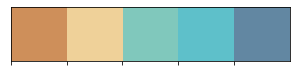

In [1]:
# Libraries
import wandb
import pandas as pd
import numpy as np
import re
import os
import string
from datetime import datetime
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from wordcloud import WordCloud, ImageColorGenerator
from wordcloud import STOPWORDS as stopwords_wc
from statsmodels.tsa.stattools import adfuller       ### Augmented Dickey Fuller

import cupy
import cudf
import cuml
from cuml.tsa.arima import ARIMA

# Color palette
my_colors = ["#ce8f5a", "#efd199", "#80c8bc", "#5ec0ca", "#6287a2"]
sns.palplot(sns.color_palette(my_colors))

# Set Style
sns.set_style("white")
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

class color:
    BOLD = '\033[1m' + '\033[93m'
    END = '\033[0m'
    
# W&B
os.environ["WANDB_SILENT"] = "true"
# Secrets 🤫
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb")

> Link to **your own key** in W&B: https://wandb.ai/authorize

In [2]:
! wandb login $secret_value_0

In [3]:
def offset_png(x, y, path, ax, zoom, offset):
    '''For adding other .png images to the graph.
    source: https://stackoverflow.com/questions/61971090/how-can-i-add-images-to-bars-in-axes-matplotlib'''
    
    img = plt.imread(path)
    im = OffsetImage(img, zoom=zoom)
    im.image.axes = ax
    x_offset = offset
    ab = AnnotationBbox(im, (x, y), xybox=(x_offset, 0), frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)
    ax.add_artist(ab)
    

    
def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        


def emoji_extractor(string, remove=False):
    '''Removes Emoji from a text.'''
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    if remove == False:
        # Extract emoji
        return emoji_pattern.findall(string)
    else:
        # Remove emoji from text
        return emoji_pattern.sub(r'', string)

def clean_emoji(x):
    if len(x) == 0:
        return ''
    else:
        return x[0]
    
    
    
def clean_tweets(df):
    '''Returns the dataframe with the tweet column cleaned.'''
    
    # ----- Remove \n, \t, \xa0 -----
    df['tweet'] = df['tweet'].apply(lambda x: x.replace('\n', ''))
    df['tweet'] = df['tweet'].apply(lambda x: x.replace('\xa0', ''))
    df['tweet'] = df['tweet'].apply(lambda x: x.replace('\t', ''))
    
    # ----- Remove pic.twitter and http:// + https:// links -----
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'http\S+', '', x))
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'https\S+', '', x))
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'pic.twitter\S+', '', x))
    
    # ----- Remove mentions and hashtags -----
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'#\S+', '', x))
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'@\S+', '', x))
    
    # ----- Extract Emojis and Remove from Tweet -----
    df['tweet_emojis'] = df['tweet'].apply(lambda x: emoji_extractor(x, remove=False))
    df['tweet_emojis'].replace('', np.nan, inplace=True)
#     df["tweet_emojis"] = df["tweet_emojis"].apply(lambda x: clean_emoji(x))
    
    df['tweet'] = df['tweet'].apply(lambda x: emoji_extractor(x, remove=True))
    
    # ----- Strip of whitespaces -----
    df['tweet'] = df['tweet'].apply(lambda x: x.strip())
    df['tweet'] = df['tweet'].apply(lambda x: ' '.join(x.split()))
    
    # ----- Remove punctuation & Make lowercase -----
    df['tweet'] = df['tweet'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    df['tweet'] = df['tweet'].apply(lambda x: x.lower())
    
    return df

### 📥 Read in Data

Tweets shape: (12562, 15) 
Bitcoin shape: (4857377, 8) 
Dogecoin shape: (2418, 7)


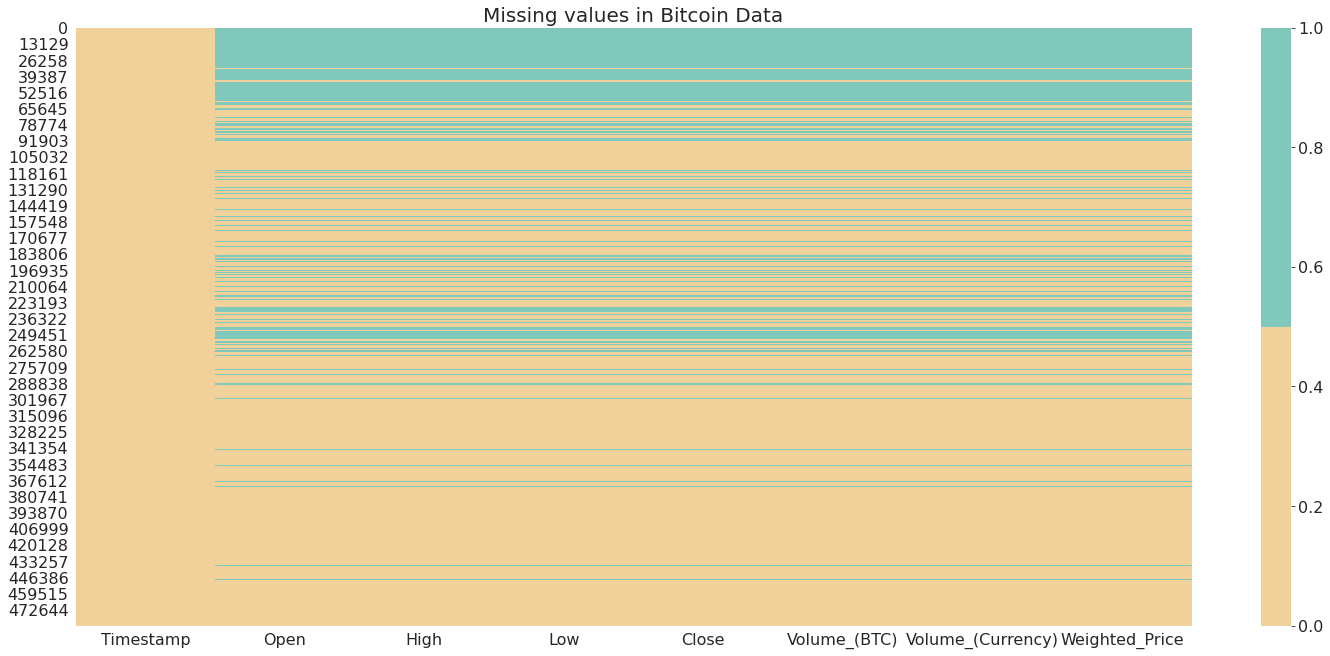

In [4]:
# === Tweets ===
tweets = pd.read_csv("../input/all-elon-musks-tweets/TweetsElonMusk.csv")
tweets = tweets[["id", "date", "time", "username", 
                 "tweet", "mentions", "urls", "photos", "replies_count", 
                 "retweets_count", "likes_count", "hashtags", "link"]]

# Create new features
tweets["year"] = tweets["date"].apply(lambda x: x.split("-")[0])
# Clean Tweets
tweets = clean_tweets(df=tweets)

# === Bitcoin ===
bitcoin = cudf.read_csv("../input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")

# === Dogecoin ===
dogecoin = pd.read_csv("../input/dogecoin-historical-data/DOGE-USD.csv")


# Prints
print(color.BOLD + "Tweets shape:" + color.END, "{}".format(tweets.shape), "\n" +
      color.BOLD + "Bitcoin shape:" + color.END, "{}".format(bitcoin.shape), "\n" +
      color.BOLD + "Dogecoin shape:" + color.END, "{}".format(dogecoin.shape))

# There are many missing values in Bitcoin data
plt.figure(figsize = (25, 11))
sns.heatmap(bitcoin.isna().as_matrix()[::10], cmap = [my_colors[1], 
                                                      my_colors[2]], xticklabels=bitcoin.columns)
plt.title("Missing values in Bitcoin Data", size=20);

# Hence, we'll drop them
bitcoin.dropna(axis=0, inplace=True)

In [5]:
# Save Tweets data to W&B Artifacts
### versioned by me like the datasets
run = wandb.init(project='bitcoin-musk', name='all_elonmusk_tweets')
artifact = wandb.Artifact(name='tweets', 
                          type='dataset')
artifact.add_file("../input/all-elon-musks-tweets/TweetsElonMusk.csv")

wandb.log_artifact(artifact)
wandb.finish()

# 1. 🚀 Elon Musk's personality

Ok, let's have a bit of fun first. Let's see how the tweets look, his progression over time and get an overall feel of how, what, when he tweets. This will help us understand a bit of his behavior, as well as address and analyse the tweets that mention **Bitcoin**.

In [6]:
run = wandb.init(project='bitcoin-musk', name='elonmusk_analysis')

## I. Tweet Count Evolution
> **📝 Note**: At the beginning of his tweeting journey, he was barely using the platform a few times in a year. 2015 was his breaking point, when he started tweeting more and more every year. It's also the year when Elon became ... well, he became **the rockstar** we know now. He was already known before, but 2015 got him on a whole new level, by announcing *Tesla's Powerwall battery* and putting out his personal life through *his biography*.

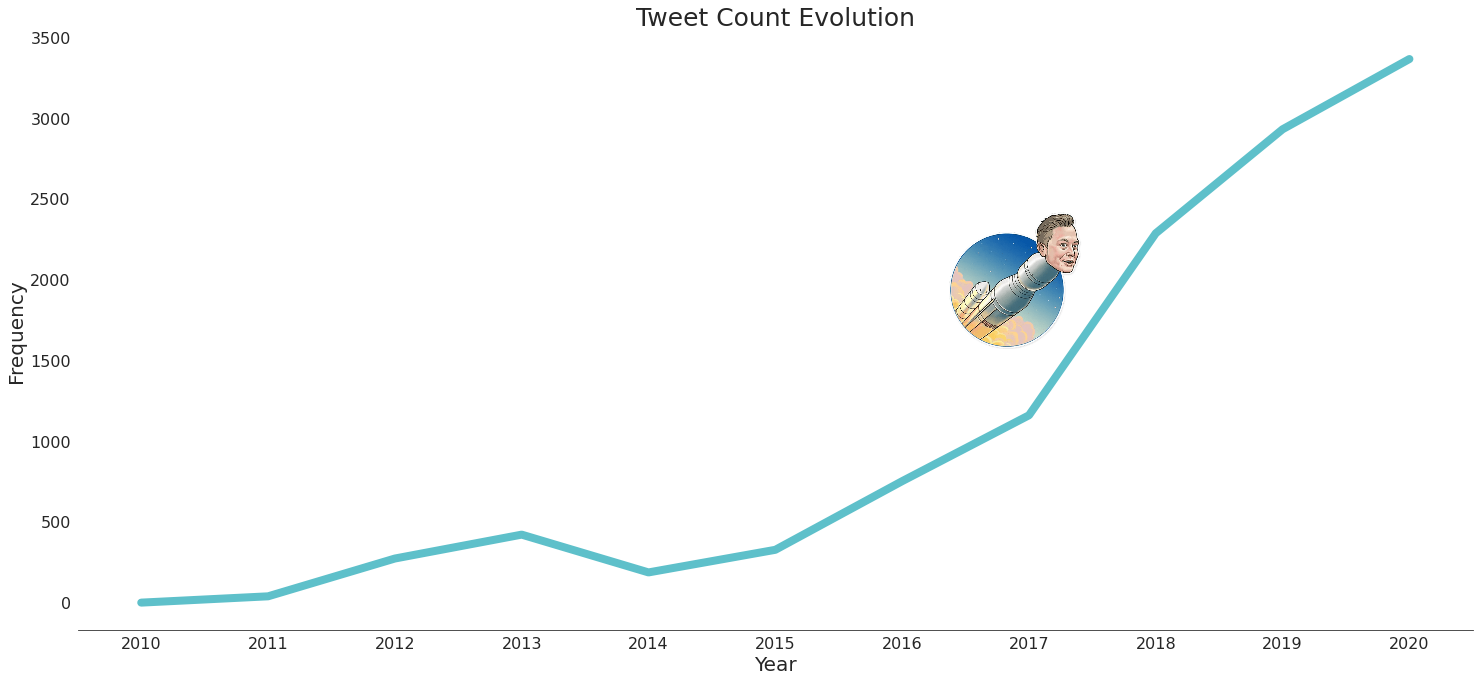

In [7]:
# Yearly evolution
date_count_df = tweets[tweets["year"]!="2021"].groupby("year")["tweet"].count().reset_index()

# Plot
plt.figure(figsize=(25, 11))
ax = sns.lineplot(data=date_count_df, x="year", y="tweet", lw=8, color=my_colors[3])
plt.title("Tweet Count Evolution", size=25)
plt.xlabel("Year", size=20)
plt.ylabel("Frequency", size=20)
sns.despine(left=True);

# Picture
path='../input/all-elon-musks-tweets/images/images/elon_rocket.png'
offset_png(x=6.9, y=2000, path=path, ax=ax, zoom=0.27, offset=0)

In [8]:
def create_wandb_lineplot(x_data, y_data, x_name, y_name, title, log):
    '''Create and save barplot in W&B Environment.
    x_data & y_data: Pandas Series containing x & y data
    x_name & y_name: strings containing axis names
    title: title of the graph
    log: string containing name of log'''
    
    # Save Graph in W&B Dashboard as well
    data = [[label, val] for (label, val) in zip(x_data, y_data)]

    table = wandb.Table(data=data, columns = [x_name, y_name])
    wandb.log({log : wandb.plot.line(table, x_name, y_name,
                                                  title=title)})

In [9]:
create_wandb_lineplot(x_data=date_count_df["year"], y_data=date_count_df["tweet"], 
                      x_name="year", y_name="tweet count", 
                      title="Tweet Count Evolution", log="tweet_evolution")

## II. Popularity

> **📝 Note**: It seems that his popularity grew with the number of tweets. He increased gradually in likes with the peak in 2020 (and I bet he'll continue in 2021 as well), but the replies reached a peak as well (he's communicating more with a broader audience, who's speaking back).
<center><img src="https://media2.giphy.com/media/2Y8Iq3xe121Ba3hUAM/giphy.gif" width=400></center>

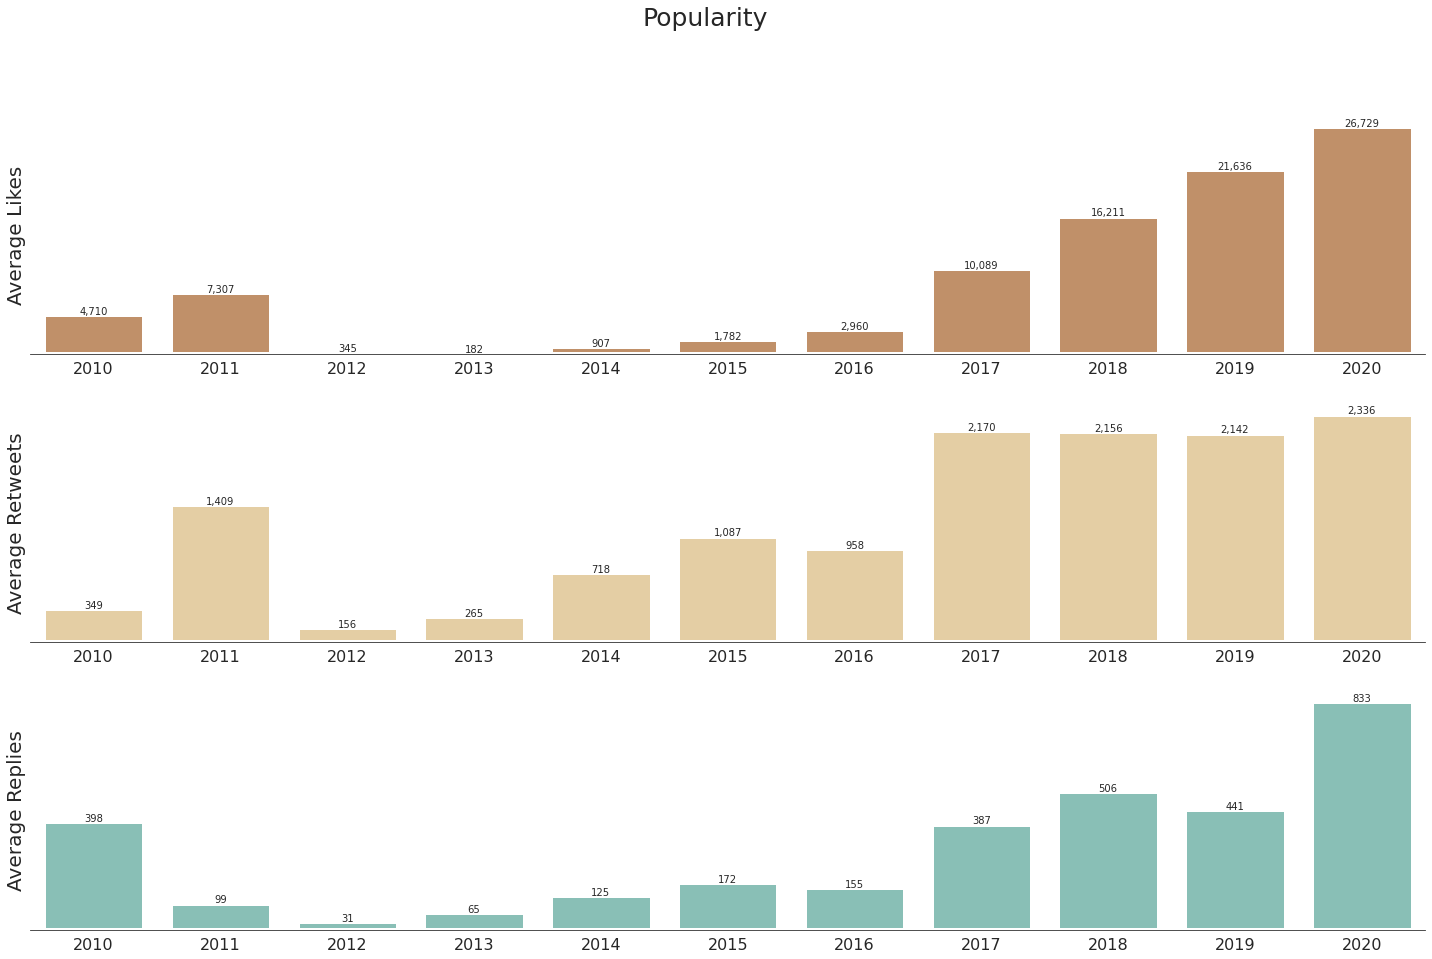

In [10]:
# Get Popularity Information
popularity = ["likes_count", "retweets_count", "replies_count"]
popularity_df = tweets[tweets["year"]!="2021"].groupby("year").agg({popularity[0] : 'sum',
                                                                    popularity[1] : 'sum',
                                                                    popularity[2] : 'sum',
                                                                    'tweet' : 'count'}).reset_index()
popularity_df["likes_count"] = popularity_df["likes_count"]/popularity_df["tweet"]
popularity_df["retweets_count"] = popularity_df["retweets_count"]/popularity_df["tweet"]
popularity_df["replies_count"] = popularity_df["replies_count"]/popularity_df["tweet"]

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(25, 15))
axs = [ax1, ax2, ax3]
plt.suptitle("Popularity", size=25)
sns.barplot(data=popularity_df, x="year", y="likes_count", lw=5, color=my_colors[0], ax=ax1)
sns.barplot(data=popularity_df, x="year", y="retweets_count", lw=5, color=my_colors[1], ax=ax2)
sns.barplot(data=popularity_df, x="year", y="replies_count", lw=5, color=my_colors[2], ax=ax3)
names = ["Average Likes", "Average Retweets", "Average Replies"]
for ax, n in zip(axs, names):
    ax.set_xlabel("", size=20)
    ax.set_ylabel(n, size=20)
    ax.get_yaxis().set_ticks([])
#     ax.title.set_text(n)
    show_values_on_bars(axs=ax, h_v="v", space=0.4)
sns.despine(left=True);

In [11]:
def create_wandb_barplot(x_data, y_data, x_name, y_name, title, log):
    '''Create and save barplot in W&B Environment.
    x_data & y_data: Pandas Series containing x & y data
    x_name & y_name: strings containing axis names
    title: title of the graph
    log: string containing name of log'''
    
    # Save Graph in W&B Dashboard as well
    data = [[label, val] for (label, val) in zip(x_data, y_data)]

    table = wandb.Table(data=data, columns = [x_name, y_name])
    wandb.log({log : wandb.plot.bar(table, x_name, y_name,
                                                  title=title)})

In [12]:
# Create W&B Barplots
create_wandb_barplot(x_data=popularity_df["year"], y_data=popularity_df["likes_count"], 
                     x_name="year", y_name="likes", 
                     title="Likes Evolution", log="likes_evolution")
create_wandb_barplot(x_data=popularity_df["year"], y_data=popularity_df["retweets_count"], 
                     x_name="year", y_name="retweets", 
                     title="Retweets Evolution", log="retweets_evolution")
create_wandb_barplot(x_data=popularity_df["year"], y_data=popularity_df["replies_count"], 
                     x_name="year", y_name="replies", 
                     title="Replies Evolution", log="replies_evolution")

## III. Most Frequent Words

> **📝 Note**:  alot of talk about **Tesla, rocket, Mars, starship, launch**. To be observed that the wording sounds super positive: yes, yeah, good, thank, people, sure. I like that a lot, he's always super positive and enthusiastin in his messages.

<center><img src="https://i.pinimg.com/originals/62/57/d3/6257d3ab7e42e96407944416ca9d3f18.gif" width = 450></center>

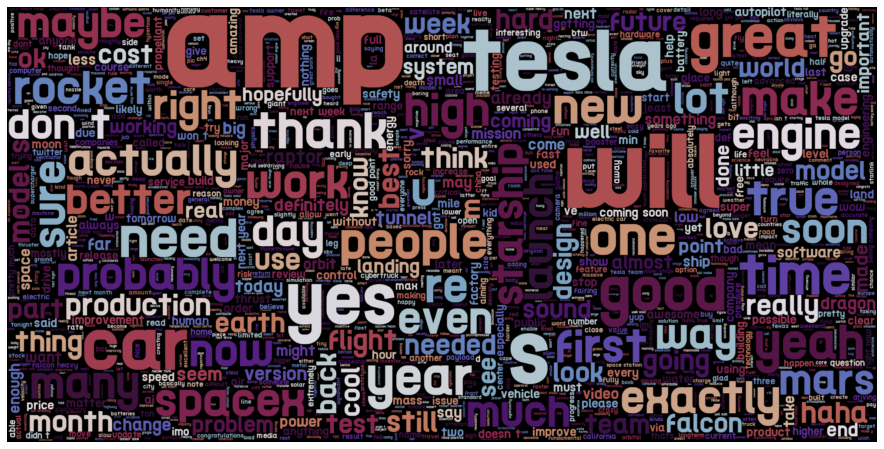

In [13]:
# Make worldcloud
all_tweets = " ".join(token for token in tweets["tweet"])
stopwords_wc = set(stopwords_wc)
font_path = "../input/all-elon-musks-tweets/acetone_font.otf"

wordcloud = WordCloud(stopwords=stopwords_wc, font_path=font_path,
                      max_words=1500,
                      max_font_size=350, random_state=42,
                      width=2000, height=1000,
                      colormap = "twilight")
wordcloud.generate(all_tweets)

# Plot
plt.figure(figsize = (16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

In [14]:
WordCloud.to_file(wordcloud, "wordcloud.png")

# Save image to W&B
wandb.log({"wordcloud": wandb.Image("./wordcloud.png")})

## IV. Let's talk about Bitcoin and ... Dogecoin?

I wanted to throw Dogecoin in there for fun. I mean ... you never know.

In [15]:
# Retrieve only Bitcoin Information
bitcoin_tweets = tweets[tweets["tweet"].str.contains("bitcoin")].reset_index(drop = True)
dogecoin_tweets = tweets[tweets["tweet"].str.contains("dogecoin")].reset_index(drop = True)

# Information
print(color.BOLD + "% of tweets about Bitcoin:" + color.END, "{:.3}%".format(bitcoin_tweets.shape[0]/tweets.shape[0]*100), "\n" +
      color.BOLD + "% of tweets about Dogecoin:" + color.END, "{:.3}%".format(dogecoin_tweets.shape[0]/tweets.shape[0]*100))

top = bitcoin_tweets.sort_values("likes_count", ascending=False)[:7]["tweet"]
print("\n", color.BOLD + "Most liked BITCOIN tweets:" + color.END)
for k, text in enumerate(top):
    print(f"{k+1}. {text}")
    
top = dogecoin_tweets.sort_values("likes_count", ascending=False)[:7]["tweet"]
print("\n", color.BOLD + "Most liked DOGECOIN tweets:" + color.END)
for k, text in enumerate(top):
    print(f"{k+1}. {text}")

% of tweets about Bitcoin: 0.111% 
% of tweets about Dogecoin: 0.0796%

 Most liked BITCOIN tweets:
1. you can now buy a tesla with bitcoin
2. btc bitcoin is an anagram of tbcthe boring company what a coincidence
3. bitcoin is my safe word
4. tesla is using only internal amp open source software amp operates bitcoin nodes directly bitcoin paid to tesla will be retained as bitcoin not converted to fiat currency
5. pay by bitcoin capability available outside us later this year
6. bitcoin is almost as bs as fiat money
7. bitcoin is not my safe word

 Most liked DOGECOIN tweets:
1. dogecoin is the people’s crypto
2. bought some dogecoin for lil x so he can be a toddler hodler
3. spacex is going to put a literal dogecoin on the literal moon
4. if major dogecoin holders sell most of their coins it will get my full support too much concentration is the only real issue imo
5. dogecoin rulz
6. origin of doge day afternoon the ancient romans sacrificed a dogecoin at the beginning of the doge day

In [16]:
wandb.finish()

> The [W&B Dashboard](https://wandb.ai/andrada/bitcoin-musk?workspace=user-andrada):

<center><img src="https://i.imgur.com/Vl8Hixr.png" width=800></center>

# 2. 📈 Predict Future Bitcoin Price using RAPIDS

> We'll use the RAPIDS distribution for this experiment, as our **data is extremely large** (more than 3 million observations). You can find out more about [RAPIDS and cuml here](https://github.com/rapidsai/cuml/tree/branch-0.20/notebooks).

In [17]:
run = wandb.init(project='bitcoin-musk', name='bitcoin_analysis')

## I. Analyse Bitcoin Evolution

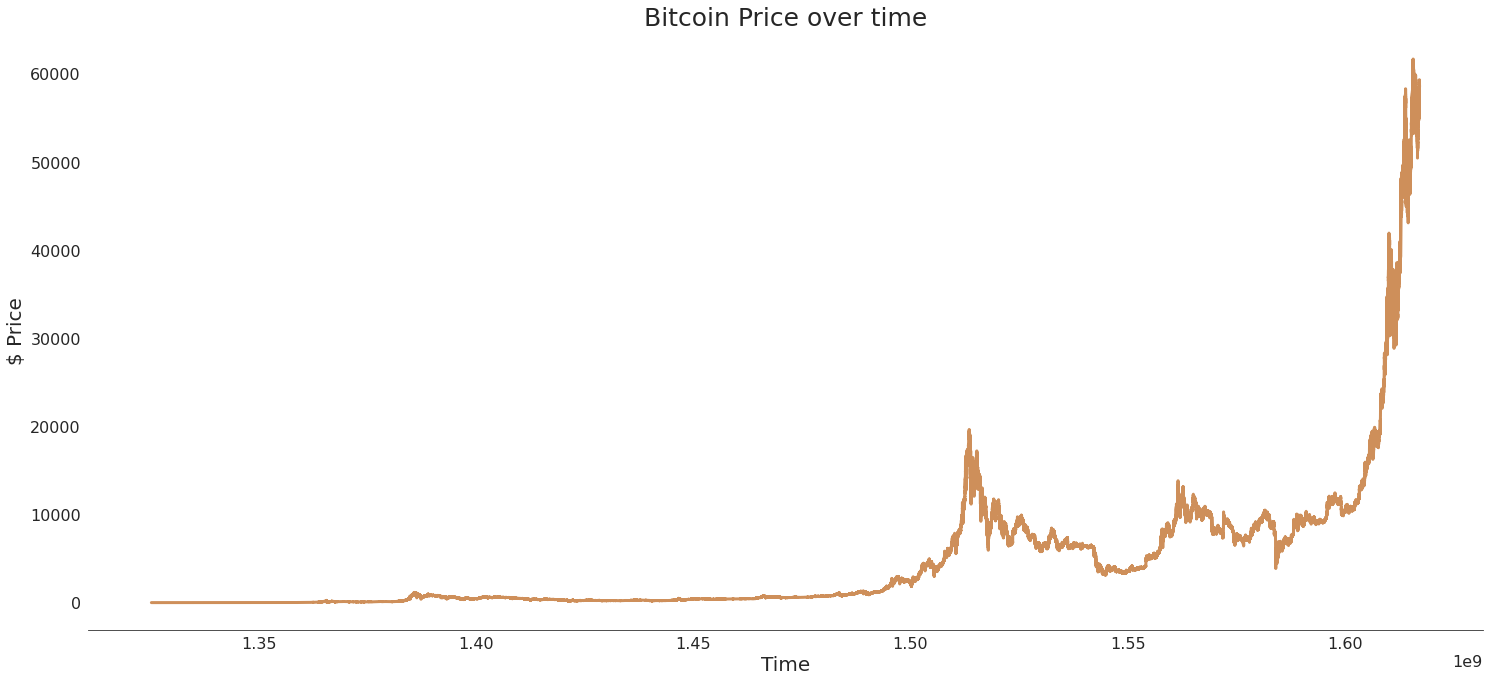

In [18]:
plt.figure(figsize = (25, 11))
plt.plot(bitcoin["Timestamp"].to_array(), bitcoin["Weighted_Price"].to_array(), color=my_colors[0], lw=3)
plt.title("Bitcoin Price over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20);

In [19]:
# Log to W&B
create_wandb_lineplot(x_data=bitcoin["Timestamp"][::50].to_array(), y_data=bitcoin["Weighted_Price"][::50].to_array(), 
                     x_name="timestamp", y_name="$price", 
                     title="Price Evolution", log="price_evolution")

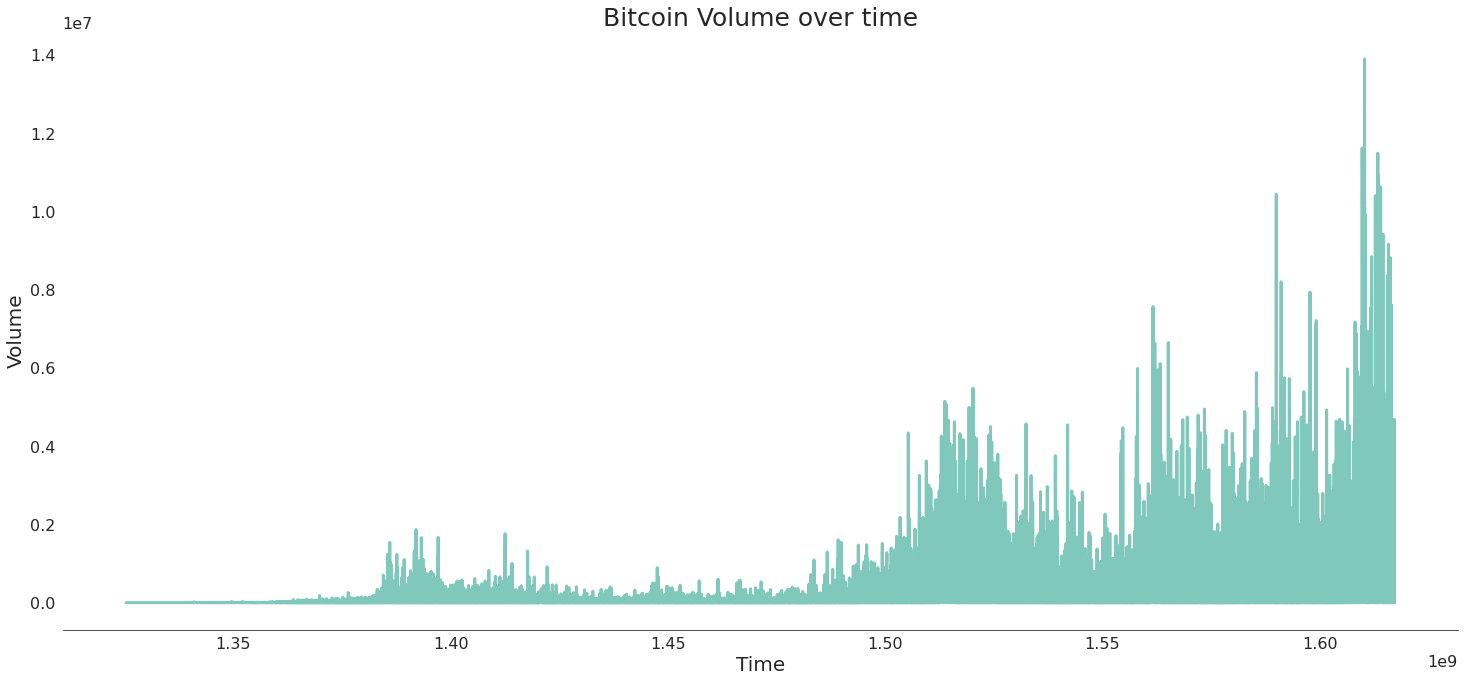

In [20]:
plt.figure(figsize = (25, 11))
plt.plot(bitcoin["Timestamp"].to_array(), bitcoin["Volume_(Currency)"].to_array(), color=my_colors[2], lw=3)
plt.title("Bitcoin Volume over time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("Volume", size=20);

In [21]:
# Log to W&B
create_wandb_lineplot(x_data=bitcoin["Timestamp"][::50].to_array(), y_data=bitcoin["Volume_(Currency)"][::50].to_array(), 
                     x_name="timestamp", y_name="volume", 
                     title="Volume Evolution", log="volume_evolution")

In [22]:
wandb.finish()

> The [W&B Dashboard](https://wandb.ai/andrada/bitcoin-musk?workspace=user-andrada):

<center><img src="https://i.imgur.com/N6m3nyh.png" width=800></center>

## II. Testing Stationarity

Our time series data **can have a trend or not**. It is of the utmost importance to determine how the series is behaving before applying any model to it.

> **Augmented Dicky Fuller test**: it determines how strongly a time series is defined by a trend.

**Hypothesis**:
1. Null Hypothesis (H0): Null hypothesis of the test is that the time series can be represented by a unit root that **is not stationary**.
2. Alternative Hypothesis (H1): Alternative Hypothesis of the test is that the time series **is stationary**.

### Why is Stationarity Important?
For data to be stationary, the statistical properties of a system **do not change over time**. This does not mean that the values for each data point have to be the same, but the overall behavior of the data should remain constant.

If the data is non-stationary (meaning it has a trend), we need to **remove** it in order to proceed with the analysis.

*My Reference: [Bitcoin Price Prediction](https://towardsdatascience.com/bitcoin-price-prediction-using-time-series-forecasting-9f468f7174d3)*

In [23]:
run = wandb.init(project='bitcoin-musk', name='stationarity')

In [24]:
def test_stationarity(x, log="non-stationary"):
    '''Test stationarity of a Time Series variable.'''
    
    # Perform Dickey Fuller test    
    result = adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue=result[1]
    
    for key,value in result[4].items():
        if result[0]>value:
            print(color.BOLD + "The graph is non stationary! (it has a trend)" + color.END)
            wandb.log({log : round(result[1], 5)})
            break
        else:
            print(color.BOLD + "The graph is stationary! (it doesn't have a trend)" + color.END)
            wandb.log({log : round(result[1], 5)})
            break;
    
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f ' % (key, value))
    
    # Determing rolling statistics
    rolmean = x.rolling(window=22,center=False).mean()
    rolstd = x.rolling(window=12,center=False).std()
    
    # Plot rolling statistics:
    plt.figure(figsize=(25, 11))
    orig = plt.plot(x, color=my_colors[0], lw=8, label='Original')
    mean = plt.plot(rolmean, color=my_colors[2], lw=2.5, ls="--",  label='Rolling Mean')
    std = plt.plot(rolstd, color=my_colors[3], lw=3, label = 'Rolling Std')
    plt.legend(loc='best', fontsize=20)
    plt.title('Rolling Mean & Standard Deviation', size=25)
    plt.show(block=False)
    
    # Log to W&B
    create_wandb_lineplot(x_data=pd.Series(range(len(rolmean))), y_data=pd.Series(rolmean), 
                          x_name="timestamp", y_name="rolmean", 
                          title="Stationarity Analysis", log=log)

ADF Stastistic: 4.695348
p-value: 1.000000
The graph is non stationary! (it has a trend)
Critical values:
	1%: -3.430 
	5%: -2.862 
	10%: -2.567 


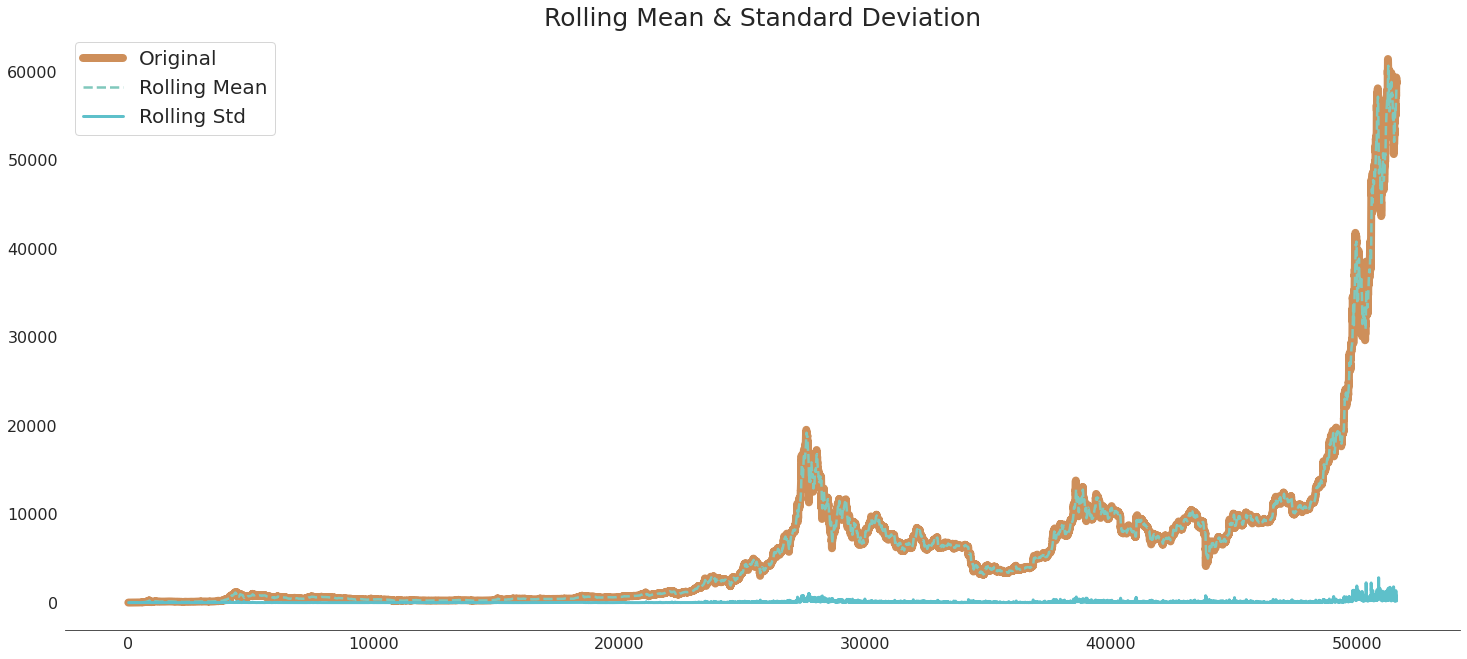

In [25]:
price = pd.Series(bitcoin["Weighted_Price"][::70].to_array())
test_stationarity(price, log="non-stationary")

And surprise surprise! The series has a trend (is non stationary). We could have noticed that by only using our naked eye, but we always need to double check.

## III. From non-stationarity to stationarity
Now that we now our series has a trend, we need to remove it in order to proceed with the models.

We can do that by applying a **natural log** to our series. Let's see how that's done!

ADF Stastistic: -3.434271
p-value: 0.009845
The graph is stationary! (it doesn't have a trend)
Critical values:
	1%: -3.430 
	5%: -2.862 
	10%: -2.567 


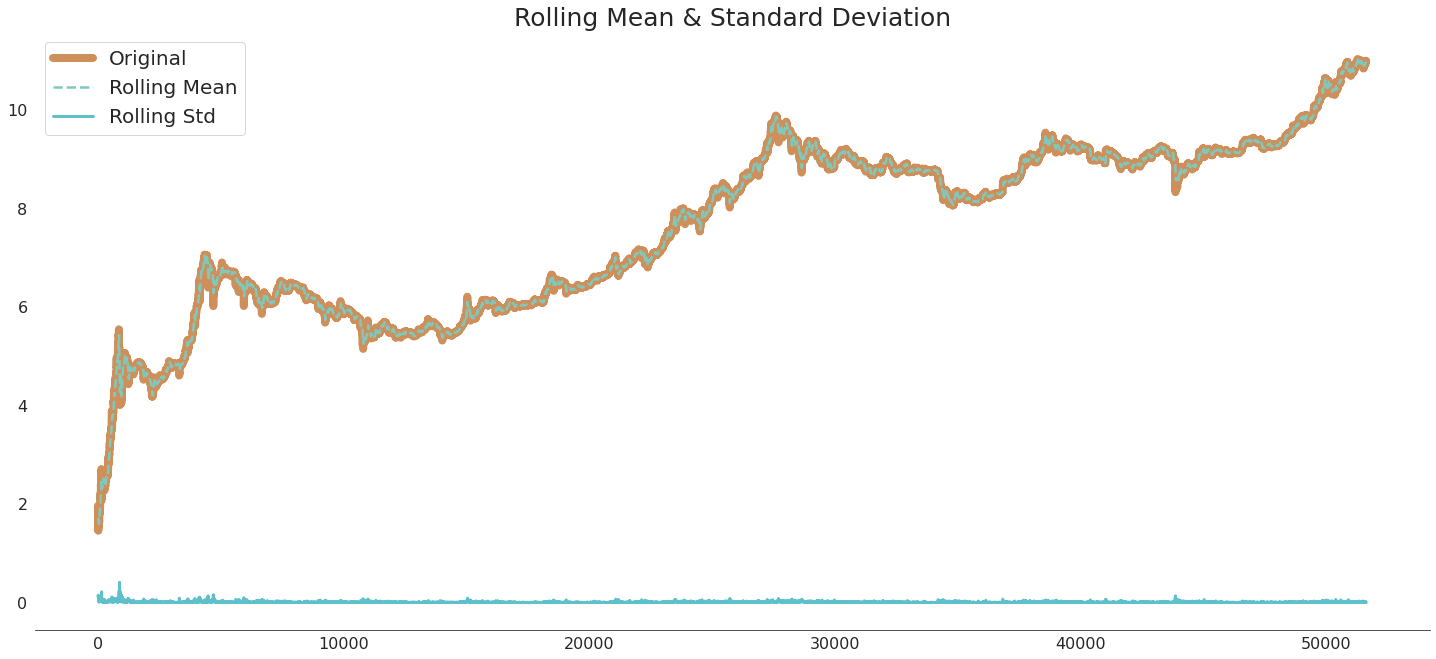

In [26]:
# Adjust by applying natural log over the series
adjusted_price = cupy.log(bitcoin["Weighted_Price"])

price_adjusted = pd.Series(cupy.asnumpy(adjusted_price)[::70])
test_stationarity(price_adjusted, log="stationary")

In [27]:
# Save the price with no trend into a new variable
bitcoin["log_price"] = adjusted_price

In [28]:
wandb.finish()

## IV. What tipe of ARIMA should I choose?

### ARIMA:
* AR: Auto Regressive model
* I: Integrated
* MA: Moving Average

Let's take them step by step :)

### Auto Regressive Model

> An autoregressive (AR) model **predicts future behavior based on past behavior**. It's used for forecasting when there is **some correlation between values in a time series** and the values that precede and succeed them.

**Criterias**

Log Likelihood, Akaike and Bayesian Information Criterion are indicators that tell us how well our model is performing, meaning **how much information it's lost**. The less information lost, the better the model. Hence, we'll try to tweak these parameters and get ourselves the best model.

In [29]:
# Fit an ARI model - AR(1) + I(1)
ar_model = ARIMA(bitcoin["Weighted_Price"][::100], order=(1,1,0), fit_intercept=True)
ar_model.fit()

# Print Information on the model
print(color.BOLD + "log-likelihood (smaller the better):" + color.END, "{:,.8}".format(ar_model.llf[0]))
print(color.BOLD + "\nCorrected Akaike Information Criterion (AICc) (smaller the better):" + color.END, "{:,.8}".format(ar_model.aicc[0]))
print(color.BOLD + "\nBayesian Information Criterion (BIC) (smaller the better):" + color.END, "{:,.8}".format(ar_model.bic[0]))

log-likelihood (smaller the better): -230,366.49

Corrected Akaike Information Criterion (AICc) (smaller the better): 460,738.98

Bayesian Information Criterion (BIC) (smaller the better): 460,764.46


### Moving Average Model
> The moving-average model specifies that the output variable **depends linearly on the current and various past values** of a stochastic (imperfectly predictable) term.

In [30]:
# Fit an MA model - I(1) + MA(1)
ma_model = ARIMA(bitcoin["Weighted_Price"][::100], order=(0,1,1), fit_intercept=True)
ma_model.fit()

# Print Information on the model
print(color.BOLD + "log-likelihood (smaller the better):" + color.END, "{:,.8}".format(ma_model.llf[0]))
print(color.BOLD + "\nCorrected Akaike Information Criterion (AICc) (smaller the better):" + color.END, "{:,.8}".format(ma_model.aicc[0]))
print(color.BOLD + "\nBayesian Information Criterion (BIC) (smaller the better):" + color.END, "{:,.8}".format(ma_model.bic[0]))

log-likelihood (smaller the better): -230,365.11

Corrected Akaike Information Criterion (AICc) (smaller the better): 460,736.21

Bayesian Information Criterion (BIC) (smaller the better): 460,761.7


### Auto Regressive Integrated Moving Average

> Explains a given time series based on its own past values, that is, its own **lags** and the **lagged** forecast errors, so that equation can be used to forecast future values.

In [31]:
# Fit an MARIMA model AR(1) + I(1) + MA(2)
arima_model = ARIMA(bitcoin["Weighted_Price"][::100], order=(1, 1, 2), fit_intercept=True)
arima_model.fit()

# Print Information on the model
print(color.BOLD + "log-likelihood (smaller the better):" + color.END, "{:,.8}".format(arima_model.llf[0]))
print(color.BOLD + "\nCorrected Akaike Information Criterion (AICc) (smaller the better):" + color.END, "{:,.8}".format(arima_model.aicc[0]))
print(color.BOLD + "\nBayesian Information Criterion (BIC) (smaller the better):" + color.END, "{:,.8}".format(arima_model.bic[0]))

log-likelihood (smaller the better): -230,338.2

Corrected Akaike Information Criterion (AICc) (smaller the better): 460,686.41

Bayesian Information Criterion (BIC) (smaller the better): 460,728.88


## V. Predicting Bitcoin Price

Now, let's predict Bitcoin Prices by using an ARIMA (1, 1, 2) model.

The steps will be:
* Selecting only a small portion of data `test`: we don't have to train on all 3 mil rows of data. Choosing data that is closer 

In [32]:
run = wandb.init(project='bitcoin-musk', name='arima_predict')

In [33]:
def append(my_list, value):
    '''.append() function does not exist for arrays (only for lists).
    So we will make a function that tweaks this a bit.'''
    
    # Convert from array to list
    my_list = my_list.tolist()
    # Append new value
    my_list.append(value)
    # Convert back to array
    my_list = cupy.asarray(my_list)
    
    return my_list

In [34]:
# ========== VARIABLES ==========
percent = 0.99           ### percent of data to be used
no_future_preds = 10    ### number of values to predict in the future
# ===============================

wandb.log({'percent_of_data':percent, 'future_values':no_future_preds})

In [35]:
# Select only a small portion of the data
sample_data = adjusted_price[percent*len(adjusted_price) : len(adjusted_price)]
print(color.BOLD + "All data shape:" + color.END, sample_data.shape)

# Split into Train and Test data
split = len(sample_data) - no_future_preds

train_price = sample_data[:split]
test_price = sample_data[split:]

pred_list, actual_list, error_list = [], [], []

All data shape: (36138,)


In [36]:
# For each value in the 100 prices in test set
for k in range(len(test_price)):
    
    # Fit the arima model onto train data
    arima_model = ARIMA(train_price, order=(1, 1, 2), fit_intercept=True)
    arima_model.fit()
    
    # Predict next value
    predicted_out = arima_model.forecast(1)[0]
    predicted_out = np.exp(predicted_out)
    
    # Append the original value to training data
    actual_out = test_price[k]
    train_price = append(my_list=train_price, value=cupy.asnumpy(actual_out).min())
    actual_out = np.exp(actual_out)
    
    # Compute the error of model
    error = (abs(predicted_out - actual_out) / actual_out) * 100
    print(color.BOLD + f"Step {k}. | " + color.END, "Predicted: {} | Actual: {} | ERROR: {}".format(predicted_out, actual_out, error))
    
    # Append information
    pred_list.append(predicted_out)
    actual_list.append(actual_out)
    error_list.append(error)
    
    # Log to W&B
    wandb.log({"predicted": float(predicted_out[0])}, step=k)
    wandb.log({"actual": float(actual_out)}, step=k)
    wandb.log({"error": float(error[0])}, step=k)

[W] [15:30:14.343282] fit: Some batch members had optimizer problems
Step 0. |  Predicted: [58641.53118348] | Actual: 58677.43570200001 | ERROR: [0.06118965]
[W] [15:30:21.672775] fit: Some batch members had optimizer problems
Step 1. |  Predicted: [58682.59815333] | Actual: 58680.02126000003 | ERROR: [0.00439143]
[W] [15:30:27.575346] fit: Some batch members had optimizer problems
Step 2. |  Predicted: [58680.96718882] | Actual: 58702.294657000006 | ERROR: [0.03633157]
[W] [15:30:33.458433] fit: Some batch members had optimizer problems
Step 3. |  Predicted: [58705.98013051] | Actual: 58745.14535099997 | ERROR: [0.06666971]
[W] [15:30:39.374170] fit: Some batch members had optimizer problems
Step 4. |  Predicted: [58751.04409506] | Actual: 58731.946927 | ERROR: [0.03251581]
[W] [15:30:45.261027] fit: Some batch members had optimizer problems
Step 5. |  Predicted: [58731.2575742] | Actual: 58692.75333899996 | ERROR: [0.06560305]
[W] [15:30:51.174925] fit: Some batch members had optimiz

> This is how the logs look now in our Dashboard:

<center><img src="https://i.imgur.com/CIrYGU7.png" width=800></center>

In [37]:
# Prepare info to be plotted
error_list = [l[0].tolist() for l in error_list]
pred_list = [l[0].tolist() for l in pred_list]
actual_list = [l.tolist() for l in actual_list]

Average Error: 0.03957276711269994


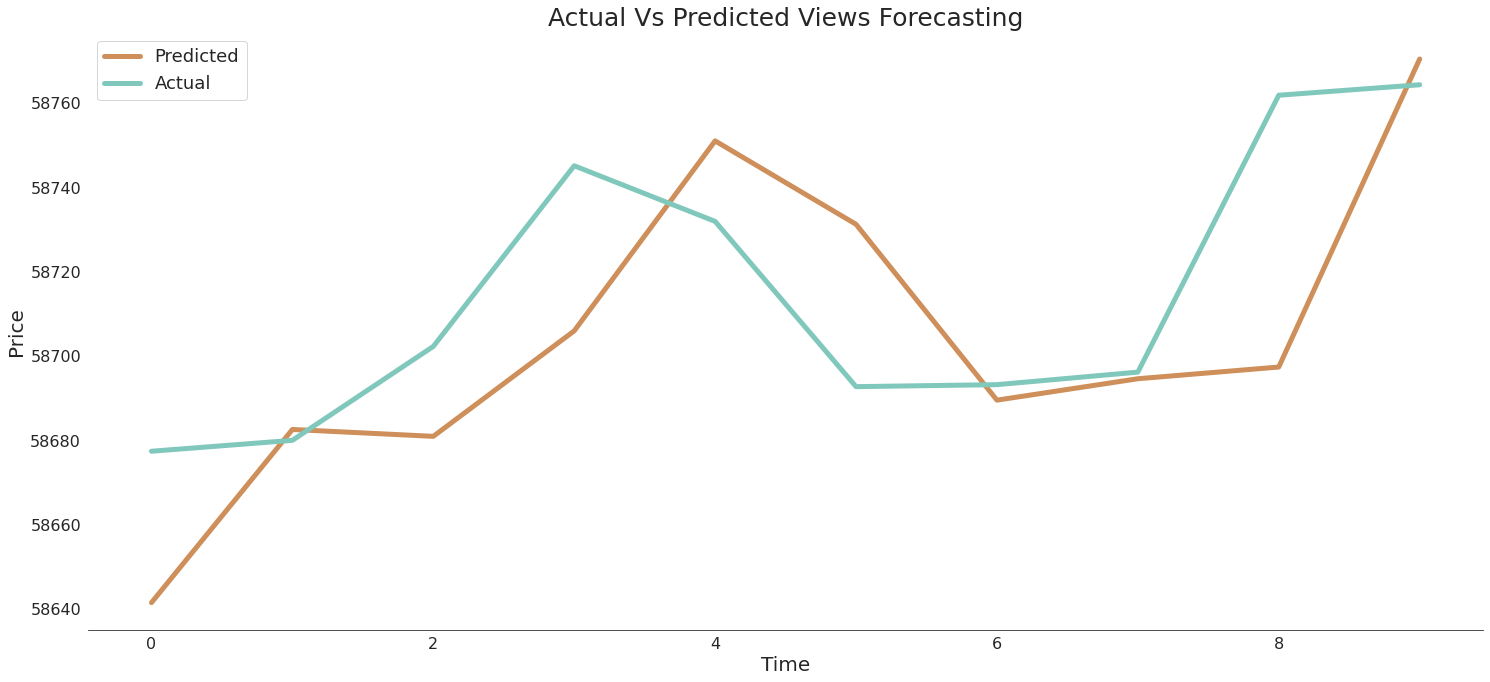

In [38]:
print(color.BOLD + 'Average Error:' + color.END, (sum(error_list) / float(len(error_list))))

# Plot
plt.figure(figsize=(25, 11))
time = [t for t in range(len(test_price))]

plt.plot(time, pred_list, color=my_colors[0], label="Predicted", lw=5)
plt.plot(time, actual_list, color=my_colors[2], label="Actual", lw=5)
plt.title('Actual Vs Predicted Views Forecasting', size=25)
plt.xlabel('Time', size=20)
plt.ylabel('Price', size=20)
plt.legend(fontsize=18);

In [39]:
# Log to W&B
create_wandb_lineplot(x_data=time, y_data=pred_list, 
                      x_name="time", y_name="predictions", 
                      title="Prediction Forecast", log="prediction")
create_wandb_lineplot(x_data=time, y_data=actual_list, 
                      x_name="time", y_name="actuals", 
                      title="Actuals Values", log="actuals")

> **Pro Tip**: If you would like to change something in the W&B Graph and you want it to show in the Dashboard, simply click "Detach" at the top after you've made your changes:

<center><img src="https://i.imgur.com/NjIxgxj.png" width=800></center>

### Use ARIMA to forecast the Future

In [40]:
def plot_prediction(actual, prediction, zoom=5000):
    '''Plot actual and forecasted values in time.
    actual: a GPU array of actual data in time
    prediction: the predicted values from ARIMA model
    zoom: number of observations (out of 3 million) to plot'''

    actual_range = actual.count()
    predict_range = prediction.count()
    all_range = actual_range + predict_range
    
    plt.figure(figsize = (25, 10))
    plt.plot(range(actual_range-zoom, actual_range), actual[actual_range-zoom:actual_range].to_array(), color=my_colors[0], lw=4, label="Actual")
    plt.plot(range(actual_range, all_range), prediction.to_array(), color=my_colors[3], lw=4, ls="--", label="Predicted")
    plt.legend(fontsize=20)
    plt.title("Prediction of Bitcoin Price", size=25)
    plt.xlabel("Time", size=20)
    plt.ylabel("log Price", size=20);

In [41]:
arima_model2 = ARIMA(sample_data, order=(1, 1, 2), fit_intercept=True)
arima_model2.fit()
predictions = arima_model2.forecast(30)

[W] [15:31:23.646191] fit: Some batch members had optimizer problems


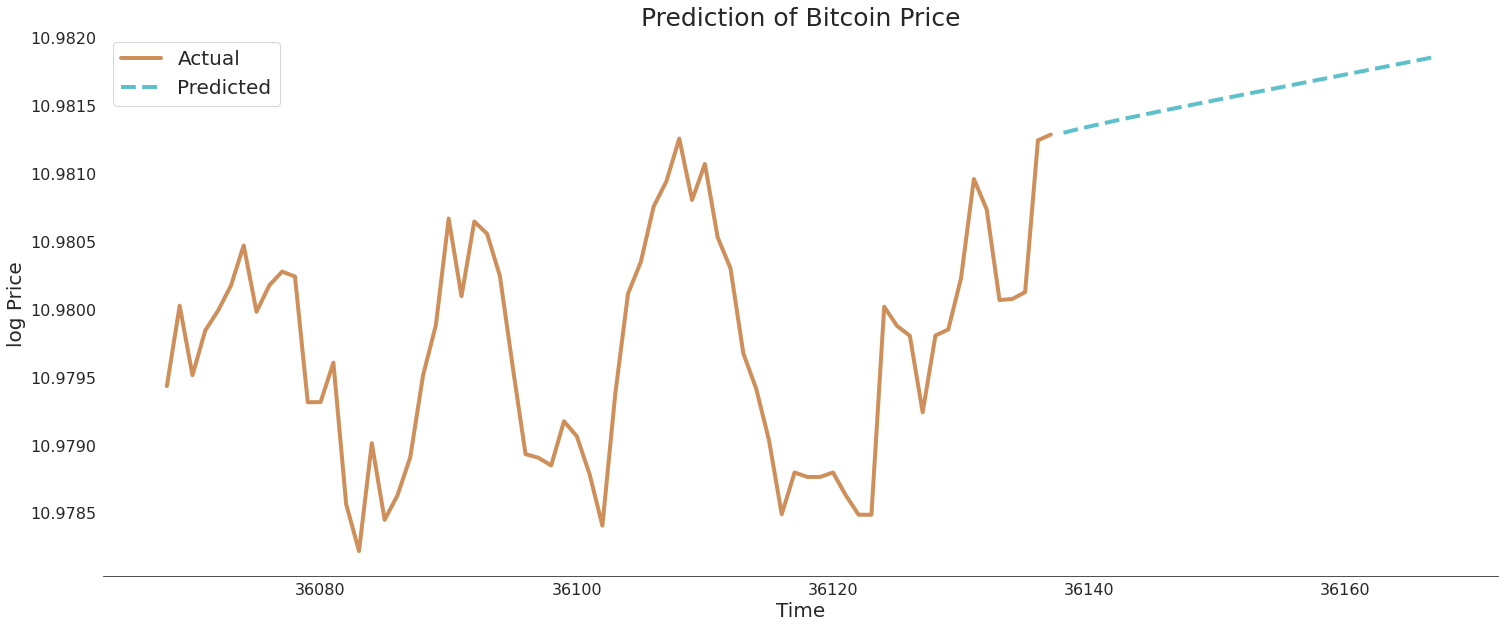

In [42]:
plot_prediction(actual=cudf.Series(sample_data), prediction=cudf.Series(predictions), zoom=70)

In [43]:
wandb.finish()

> The [W&B Dashboard](https://wandb.ai/andrada/bitcoin-musk?workspace=user-andrada):

<center><img src="https://i.imgur.com/AKCHbUi.png" width=800></center>

# 3. 🖇 Is there correlation between Bitcoin and Elon Musk's Tweets?

Let's find out!

In order to do this, I've decided to look at the points in time when Elon tweeted about Bitcoin.

<center><img src="https://sm.pcmag.com/t/pcmag_uk/news/e/elon-musk-/elon-musk-tells-followers-to-use-signal-messaging-app-amid-w_p8u9.1920.jpg" width = 450></center>

## Overall View

1. pay by bitcoin capability available outside us later this year
2. tesla is using only internal amp open source software amp operates bitcoin nodes directly bitcoin paid to tesla will be retained as bitcoin not converted to fiat currency
3. you can now buy a tesla with bitcoin
4. btc bitcoin is an anagram of tbcthe boring company what a coincidence
5. to be clear i am not an investor i am an engineer i don’t even own any publicly traded stock besides tesla however when fiat currency has negative real interest only a fool wouldn’t look elsewhere bitcoin is almost as bs as fiat money the key word is “almost”
6. tesla’s action is not directly reflective of my opinion having some bitcoin which is simply a less dumb form of liquidity than cash is adventurous enough for an sampp500 company
7. bitcoin is almost as bs as fiat money
8. bitcoin is my safe word
9. toss a bitcoin to ur witcher
10. i still only own 025 bitcoins btw
11. pretty much although massive currency issuance by govt centra

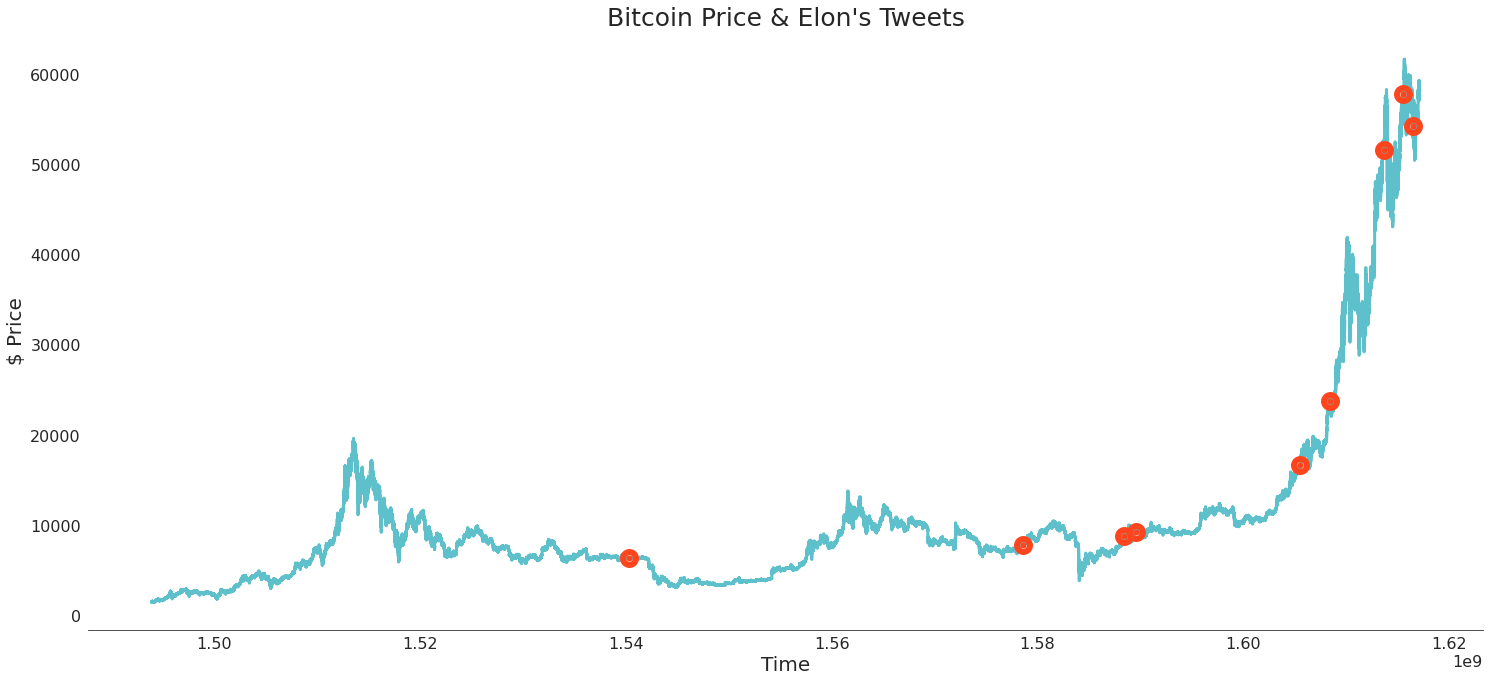

In [44]:
# Get bitcoin info
btc_tweets = tweets[tweets["tweet"].str.contains("bitcoin")].reset_index(drop = True)
# Convert date to number
btc_tweets["date"] = btc_tweets["date"].apply(lambda x: datetime.fromisoformat(x).timestamp())
# Get only latest bitcoin data (as Elon never tweeted before 2018)
btc_prices = bitcoin.sort_values("Timestamp", ascending=False).head(2000000)
timestamps = btc_tweets["date"]

for k, tweet in enumerate(btc_tweets["tweet"]): print(color.BOLD + f"{k+1}." + color.END, tweet)

# Get intersection
x_values = cupy.asnumpy(btc_prices[btc_prices["Timestamp"].isin(timestamps)]["Timestamp"])
y_values = cupy.asnumpy(btc_prices[btc_prices["Timestamp"].isin(timestamps)]["Weighted_Price"])

# Plot
plt.figure(figsize = (25, 11))
for x, y in zip(x_values, y_values):
    plt.scatter(x, y, color="#FF451D", lw=13, zorder=2)
plt.plot(btc_prices["Timestamp"].to_array(), btc_prices["Weighted_Price"].to_array(), color=my_colors[3], lw=3, zorder=1)
plt.title("Bitcoin Price & Elon's Tweets", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20);

> It doesn't really look like there is any strong correlation or that the tweets drive peaks.

## Closer Look

Let's use a magnifying glass and look closer to our points in time.

1. pay by bitcoin capability available outside us later this year
2. tesla is using only internal amp open source software amp operates bitcoin nodes directly bitcoin paid to tesla will be retained as bitcoin not converted to fiat currency
3. you can now buy a tesla with bitcoin


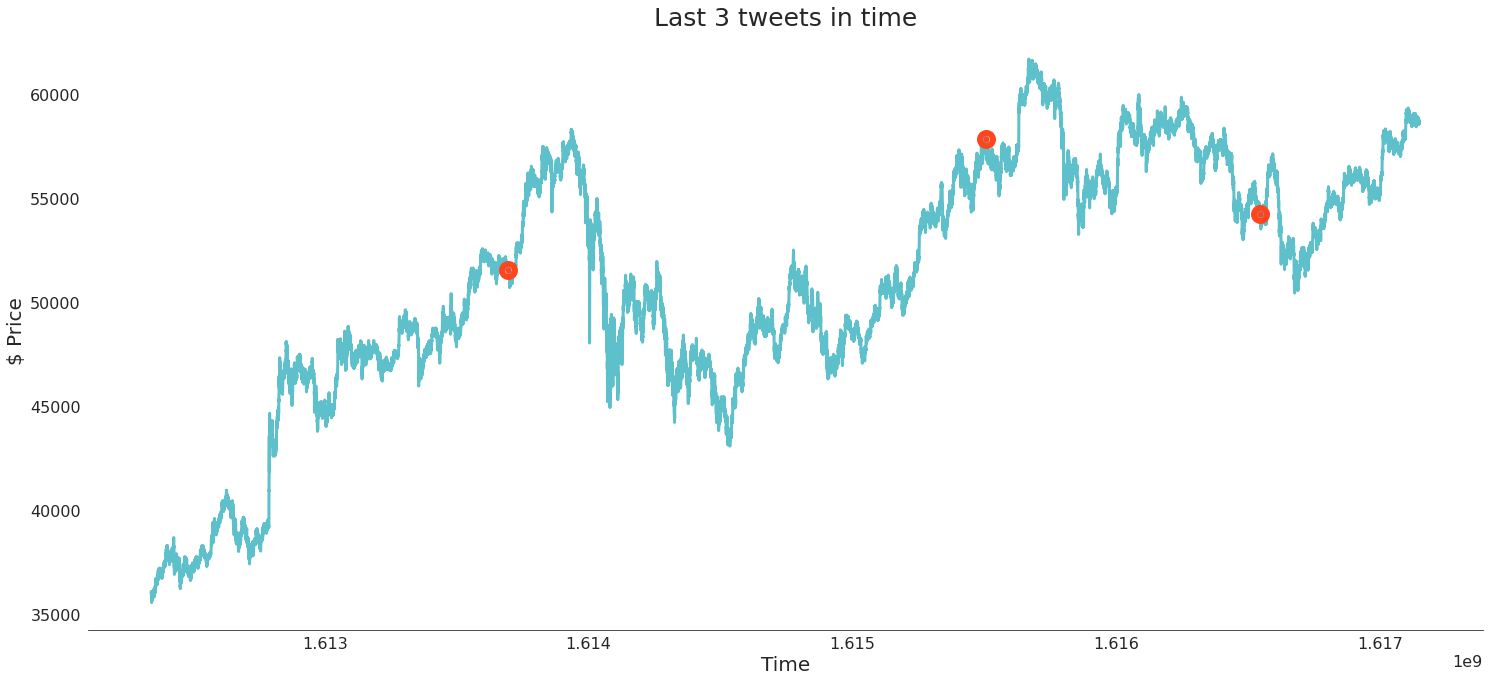

In [45]:
# Get bitcoin info
btc_tweets = tweets[tweets["tweet"].str.contains("bitcoin")].reset_index(drop = True)
# Convert date to number
btc_tweets["date"] = btc_tweets["date"].apply(lambda x: datetime.fromisoformat(x).timestamp())
# Get only latest bitcoin data (as Elon never tweeted before 2018)
btc_prices = bitcoin.sort_values("Timestamp", ascending=False).head(80000)
timestamps = btc_tweets["date"]

for k, tweet in enumerate(btc_tweets["tweet"][:3]): print(color.BOLD + f"{k+1}." + color.END, tweet)

# Get intersection
x_values = cupy.asnumpy(btc_prices[btc_prices["Timestamp"].isin(timestamps)]["Timestamp"])
y_values = cupy.asnumpy(btc_prices[btc_prices["Timestamp"].isin(timestamps)]["Weighted_Price"])

# Plot
plt.figure(figsize = (25, 11))
for x, y in zip(x_values, y_values):
    plt.scatter(x, y, color="#FF451D", lw=13, zorder=2)
plt.plot(btc_prices["Timestamp"].to_array(), btc_prices["Weighted_Price"].to_array(), color=my_colors[3], lw=3, zorder=1)
plt.title("Last 3 tweets in time", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20);

> You can observe some sudden peaks within a few days (1 do 4 days) of the making of the tweet.

# 4. 🖇 Is there correlation between Dogecoin and Elon Musk's Tweets?

Is there?

<center><img src="https://media.alephnews.ro/2021/04/musk-meme-doge.jpg" width=500></center>

1. spacex is going to put a literal dogecoin on the literal moon
2. origin of doge day afternoon the ancient romans sacrificed a dogecoin at the beginning of the doge days to appease the rage of sirius believing that the star was the cause of the hot sultry weather
3. 2022 dogecoin is dumb
4. if major dogecoin holders sell most of their coins it will get my full support too much concentration is the only real issue imo
5. bought some dogecoin for lil x so he can be a toddler hodler
6. dogecoin is the people’s crypto
7. dogecoin mode
8. dogecoin value may vary
9. dogecoin rulz
10. dogecoin might be my fav cryptocurrency it’s pretty cool


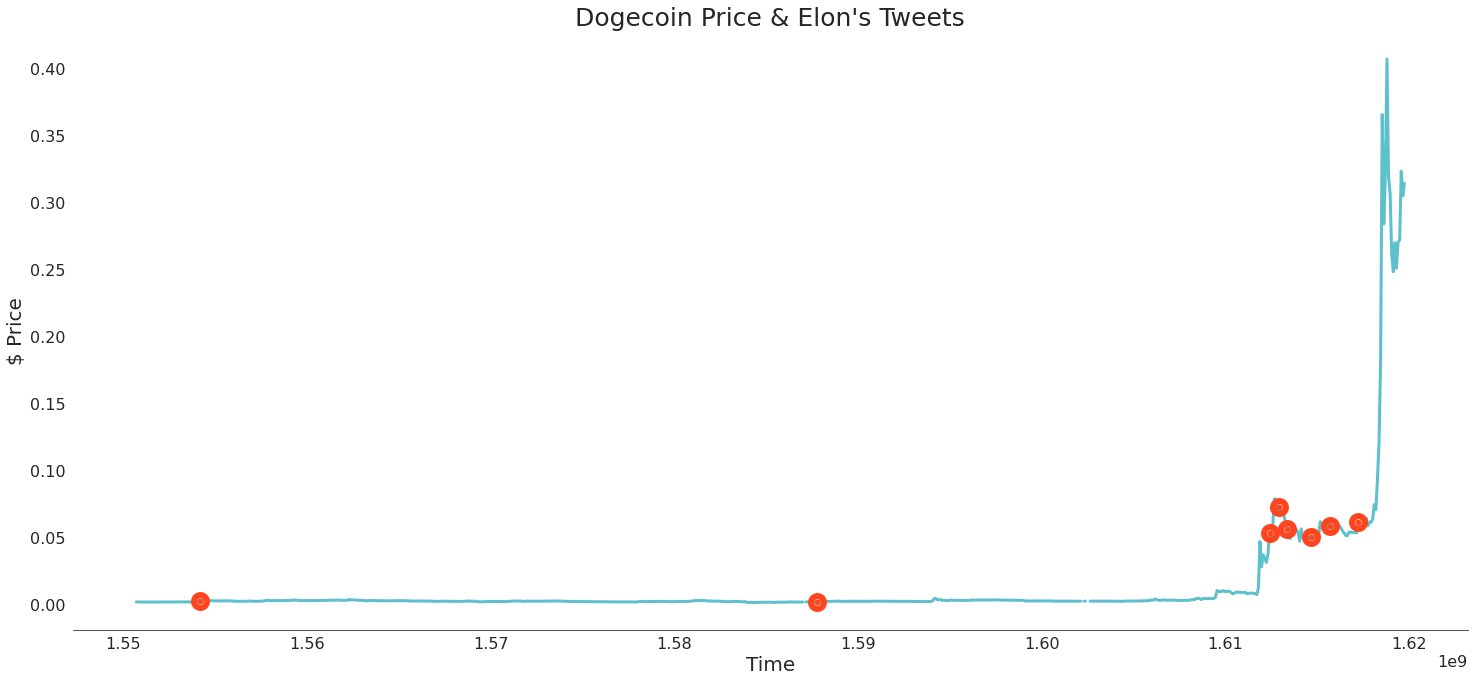

In [46]:
# Get bitcoin info
dgc_tweets = tweets[tweets["tweet"].str.contains("dogecoin")].reset_index(drop = True)
# Convert date to number
dgc_tweets["date"] = dgc_tweets["date"].apply(lambda x: datetime.fromisoformat(x).timestamp())
timestamps = dgc_tweets["date"]

dgc_prices = dogecoin.sort_values("Date", ascending=False).head(800)
dgc_prices["Date"] = dgc_prices["Date"].apply(lambda x: datetime.fromisoformat(x).timestamp())

for k, tweet in enumerate(dgc_tweets["tweet"]): print(color.BOLD + f"{k+1}." + color.END, tweet)

# Get intersection
x_values = dgc_prices[dgc_prices["Date"].isin(timestamps)]["Date"]
y_values = dgc_prices[dgc_prices["Date"].isin(timestamps)]["Adj Close"]

# Plot
plt.figure(figsize = (25, 11))
for x, y in zip(x_values, y_values):
    plt.scatter(x, y, color="#FF451D", lw=13, zorder=2)
plt.plot(dgc_prices["Date"], dgc_prices["Adj Close"], color=my_colors[3], lw=3, zorder=1)
plt.title("Dogecoin Price & Elon's Tweets", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20);

## Closer Look

1. spacex is going to put a literal dogecoin on the literal moon
2. origin of doge day afternoon the ancient romans sacrificed a dogecoin at the beginning of the doge days to appease the rage of sirius believing that the star was the cause of the hot sultry weather
3. 2022 dogecoin is dumb
4. if major dogecoin holders sell most of their coins it will get my full support too much concentration is the only real issue imo
5. bought some dogecoin for lil x so he can be a toddler hodler
6. dogecoin is the people’s crypto


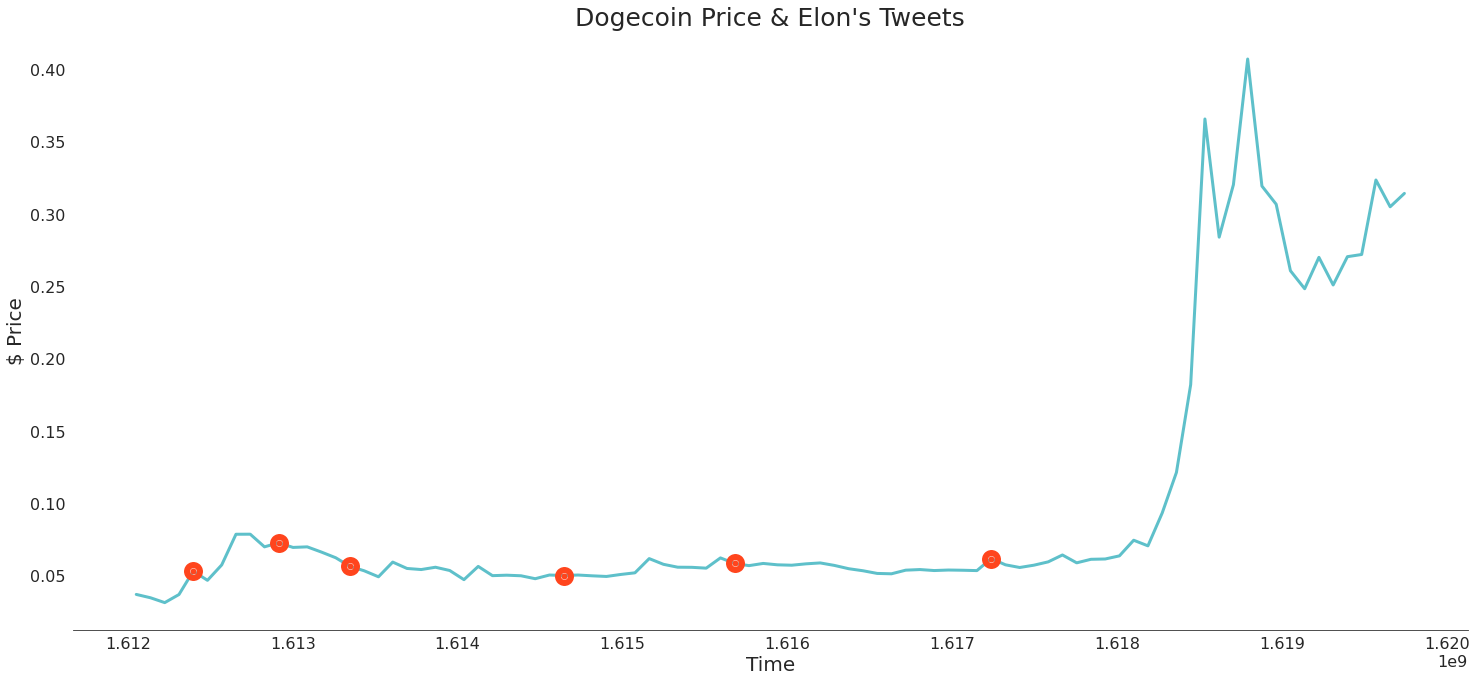

In [47]:
# Get bitcoin info
dgc_tweets = tweets[tweets["tweet"].str.contains("dogecoin")].reset_index(drop = True)
# Convert date to number
dgc_tweets["date"] = dgc_tweets["date"].apply(lambda x: datetime.fromisoformat(x).timestamp())
timestamps = dgc_tweets["date"]

dgc_prices = dogecoin.sort_values("Date", ascending=False).head(90)
dgc_prices["Date"] = dgc_prices["Date"].apply(lambda x: datetime.fromisoformat(x).timestamp())

for k, tweet in enumerate(dgc_tweets["tweet"][:6]): print(color.BOLD + f"{k+1}." + color.END, tweet)

# Get intersection
x_values = dgc_prices[dgc_prices["Date"].isin(timestamps)]["Date"]
y_values = dgc_prices[dgc_prices["Date"].isin(timestamps)]["Adj Close"]

# Plot
plt.figure(figsize = (25, 11))
for x, y in zip(x_values, y_values):
    plt.scatter(x, y, color="#FF451D", lw=13, zorder=2)
plt.plot(dgc_prices["Date"], dgc_prices["Adj Close"], color=my_colors[3], lw=3, zorder=1)
plt.title("Dogecoin Price & Elon's Tweets", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20);

### TODO:
* Import W&B overlapped graphs

# ⏳ Work in Progress

<img src="https://i.imgur.com/cUQXtS7.png">

# ⌨️🎨 Specs on how I trained using RAPIDS
### (on my local machine)
* Z8 G4 Workstation 🖥
* 2 CPUs & 96GB Memory 💾
* NVIDIA Quadro RTX 8000 🎮
* RAPIDS version 0.18 🏃🏾‍♀️